In [1]:
from nltk.probability import ELEProbDist, FreqDist
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.api import TokenizerI
from nltk.tokenize.util import align_tokens

# import punkt
from nltk.tokenize import TreebankWordTokenizer
import nltk.tokenize.punkt
from nltk.probability import FreqDist

In [2]:
SWdf = pd.read_csv('NLPout.csv')

In [3]:
d = {"TARKIN": "RED_LEADER", "WEDGE": "RED_LEADER", "RED LEADER": "RED_LEADER","BEN'S VOICE":"BEN","LUKE'S VOICE":'LUKE',"HAN'S VOICE":"HAN", "FIRST TROOPER":"TROOPER", "TROOPER VOICE":"TROOPER"}
SWdf = SWdf.replace(d)
len(d)

8

In [4]:
chars = [ 'LEIA','TROOPER','LUKE','HAN','THREEPIO','VADER','WEDGE','TARKIN','RED_LEADER','OFFICER','JABBA','BIGGS']
#'LUKE','HAN','THREEPIO',
ccorpus = SWdf.loc[SWdf['char'].isin(chars)]
ccorpus = ccorpus[['text','char']]

trainx, testx = train_test_split(ccorpus, test_size=0.2)

In [5]:
trainy = trainx.apply(tuple, axis=1)
len(trainy)

620

In [6]:
train = []
for (words, cclass) in trainy:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3]
    #print(words_filtered)
    train.append((words_filtered, cclass))
len(train)

620

In [7]:
def get_words_in_tweets(train):
    all_words = []
    for (words, cclass) in train:
      all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features



In [8]:
word_features = get_word_features(get_words_in_tweets(train))
len(word_features)

1874

In [9]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features


In [10]:
training_set = nltk.classify.apply_features(extract_features, train)
len(training_set)

620

In [11]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [12]:
def train(labeled_featuresets, estimator=ELEProbDist):
        """
        :param labeled_featuresets: A list of classified featuresets,
            i.e., a list of tuples ``(featureset, label)``.
        """
        label_freqdist = FreqDist()
        feature_freqdist = defaultdict(FreqDist)
        feature_values = defaultdict(set)
        fnames = set()

        # Count up how many times each feature value occurred, given
        # the label and featurename.
        for featureset, label in labeled_featuresets:
            label_freqdist[label] += 1
            for fname, fval in featureset.items():
                # Increment freq(fval|label, fname)
                feature_freqdist[label, fname][fval] += 1
                # Record that fname can take the value fval.
                feature_values[fname].add(fval)
                # Keep a list of all feature names.
                fnames.add(fname)

        # If a feature didn't have a value given for an instance, then
        # we assume that it gets the implicit value 'None.'  This loop
        # counts up the number of 'missing' feature values for each
        # (label,fname) pair, and increments the count of the fval
        # 'None' by that amount.
        for label in label_freqdist:
            num_samples = label_freqdist[label]
            for fname in fnames:
                count = feature_freqdist[label, fname].N()
                # Only add a None key when necessary, i.e. if there are
                # any samples with feature 'fname' missing.
                if num_samples - count > 0:
                    feature_freqdist[label, fname][None] += num_samples - count
                    feature_values[fname].add(None)

        # Create the P(label) distribution
        label_probdist = estimator(label_freqdist)

        # Create the P(fval|label, fname) distribution
        feature_probdist = {}
        for ((label, fname), freqdist) in feature_freqdist.items():
            probdist = estimator(freqdist, bins=len(feature_values[fname]))
            feature_probdist[label, fname] = probdist

        return label_probdist, feature_probdist

In [13]:
label_probdist, feature_probdist = train(training_set, estimator=ELEProbDist)

In [14]:
for c in chars:
    print(c, label_probdist.prob(c))

LEIA 0.0728
TROOPER 0.036
LUKE 0.3272
HAN 0.2008
THREEPIO 0.1528
VADER 0.052
WEDGE 0.0008
TARKIN 0.0008
RED_LEADER 0.1016
OFFICER 0.0136
JABBA 0.0072
BIGGS 0.036


In [16]:
#for c in chars:
#    print(c, feature_probdist[(c, 'contains(force)')].prob(True))

In [17]:
print( classifier.show_most_informative_features(10))

Most Informative Features
         contains(doing) = True            JABBA : LUKE   =     41.0 : 1.0
          contains(out,) = True            JABBA : LUKE   =     41.0 : 1.0
          contains(give) = True            JABBA : LUKE   =     41.0 : 1.0
          contains(only) = True            JABBA : LUKE   =     41.0 : 1.0
          contains(rest) = True            JABBA : LUKE   =     41.0 : 1.0
         contains(away.) = True            JABBA : LUKE   =     41.0 : 1.0
          contains(best) = True            JABBA : LUKE   =     41.0 : 1.0
           contains(put) = True            JABBA : LUKE   =     41.0 : 1.0
         contains(short) = True            JABBA : HAN    =     25.2 : 1.0
           contains(why) = True            JABBA : HAN    =     25.2 : 1.0
None


In [18]:
testy = testx.apply(tuple, axis=1)
len(testy)

#testy

155

In [19]:
df = []
for (words, cclass) in testy:
    testout = classifier.classify(extract_features(words.split()))
    df.append({'line': words, 'char': cclass, 'pred':
        testout})
        

predictions = pd.DataFrame(df)

In [20]:
predictions = predictions.sort_values('char')
char = list(predictions.char.unique())
char

['BIGGS',
 'HAN',
 'JABBA',
 'LEIA',
 'LUKE',
 'OFFICER',
 'RED_LEADER',
 'THREEPIO',
 'TROOPER',
 'VADER']

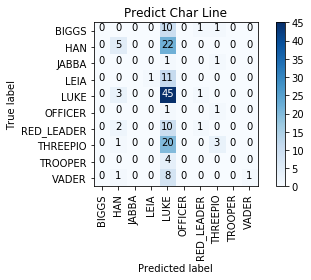

In [22]:
import itertools
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
def plot_confusion_matrix(cm, classes,
                          title='x',
                          cmap=plt.cm.Blues):
    
 #   print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnc_matrix = confusion_matrix(predictions["char"], predictions["pred"])
np.set_printoptions(precision=2)

# Compute confusion matrix
#cns_matrix = confusion_matrix(X_test["Position"], y_predp)
#np.set_printoptions(precision=2)

# Plot 
plt.figure()
plot_confusion_matrix(cnc_matrix, classes=char,
                      title='Predict Char Line')


plt.show()

# Plot 
#plt.figure()
#plot_confusion_matrix(cnc_matrix, classes=pcnames,
#                     title='Predict Char Line')


#plt.show()

